In [1]:
from inception_v4 import InceptionV4
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, model_from_json, Input
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import generate_generator, read_image_and_K_from_dir, read_48_points


%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
random.seed(7)
net = 'inceptionV4'
with_K = 'no'
save_dir = './weights/weights_' + with_K + '_K/'
from utils import SaveModelOnMAE_no, SaveModelOnMAE_head, SaveModelOnMAE_tail

# Dataset
dir_path = './data/csv_files'
train_paths, train_labels, train_K, test_paths, test_labels, test_K = read_image_and_K_from_dir(dir_path, idx_test=7)


indexes_rand = list(range(len(train_K)))
random.shuffle(indexes_rand)
train_paths, train_labels, train_K = np.asarray(train_paths)[indexes_rand].tolist(), np.asarray(train_labels)[indexes_rand].tolist(), np.asarray(train_K)[indexes_rand].tolist()

idx_validate = np.loadtxt('./data/validation_selection_index.txt').astype(int)
validate_paths, validate_labels, validate_K = np.asarray(test_paths)[idx_validate].tolist(), np.asarray(test_labels)[idx_validate].tolist(), np.asarray(test_K)[idx_validate].tolist()

indexes_rand = list(range(len(test_K)))
random.shuffle(indexes_rand)
test_paths, test_labels, test_K = np.asarray(test_paths)[indexes_rand].tolist(), np.asarray(test_labels)[indexes_rand].tolist(), np.asarray(test_K)[indexes_rand].tolist()

test_paths_48, test_labels_48, test_K_48 = read_48_points(
    dir_path='./data/csv_files', dir_points='./data/48_points', idx_test=7
)
test_paths_48, test_labels_48, test_K_48 = np.squeeze(test_paths_48).tolist(), np.squeeze(test_labels_48).tolist(), np.squeeze(test_K_48).tolist()
print('\tpath\tlabel\tK')
print('train:\t{}\t{}\t{}'.format(len(train_paths), len(train_labels), len(train_K)))
print('val:\t{}\t{}\t{}'.format(len(validate_paths), len(validate_labels), len(validate_K)))
print('test:\t{}\t{}\t{}'.format(len(test_paths), len(test_labels), len(test_K)))

/home/chengxg/anaconda2/envs/zp_py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Reading 	train and test set 	from subject 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 .csv
Reading 	validation set 		from subject 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 .csv
	path	label	K
train:	1310850	1310850	1310850
val:	64	64	64
test:	84600	84600	84600


In [2]:
def head_model(input_shape=(150, 150, 4)):
    input_tensor = Input(input_shape)
    # x = Conv2D(32, (5, 5), activation='relu', padding='valid')(input_shape)
    x = Conv2D(128, (1, 1), activation='relu')(input_tensor)
    x = Conv2D(3, (1, 1), activation='relu')(x)
    model = Model(inputs=input_tensor, outputs=x, name='head')
    return model


def tail_model(input_tensor):
    x = GlobalAveragePooling2D()(input_tensor)
    x = Dense(1, activation='relu')(x)
    model = Model(inputs=input_tensor, outputs=x, name='tail')
    return model


if with_K == 'head':
    head_model = head_model()
    body_model = Model(
        inputs=head_model.inputs,
        outputs=InceptionV4(weights='imagenet', include_top=False)(head_model.outputs)
    )
    x = body_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='relu')(x)

    model = Model(inputs=body_model.inputs, outputs=x, name=net)
    model.compile(loss='mean_absolute_error', optimizer='adam')
elif with_K == 'no':
    base_model = InceptionV4(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='relu')(x)
    model = Model(inputs=base_model.inputs, outputs=x, name=net)
    model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [3]:
batch_size_train = 32
epochs_per_iteration = 32
batch_size_validate = len(validate_labels)

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

checkpointer_best = ModelCheckpoint(
    filepath=save_dir + net + '.hdf5',
    monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)
saver_MAE = SaveModelOnMAE_no()
print('Training ...')
train_generator = generate_generator(train_paths, train_labels, train_K, batch_size_train, net=net, with_K=with_K)
validate_generator = generate_generator(validate_paths, validate_labels, validate_K, batch_size_validate, net=net, with_K=with_K)
history = model.fit_generator(
    train_generator, steps_per_epoch = np.ceil(len(train_paths)/batch_size_train/epochs_per_iteration),
    epochs=epochs_per_iteration * 2,
    validation_data=validate_generator, validation_steps=1,
    verbose=1, callbacks=[checkpointer_best, saver_MAE]
)

Training ...
Epoch 1/64
1281/1281 [==============================] - 425s 332ms/step - loss: 3.1732 - val_loss: 247158736.0000

Epoch 00001: val_loss improved from inf to 247158736.00000, saving model to ./weights/weights_no_K/inceptionV4.hdf5
Epoch 2/64
1281/1281 [==============================] - 401s 313ms/step - loss: 1.6120 - val_loss: 115797196800.0000

Epoch 00002: val_loss did not improve
Epoch 3/64
1281/1281 [==============================] - 398s 310ms/step - loss: 1.5612 - val_loss: 7127883055104.0000

Epoch 00003: val_loss did not improve
Epoch 4/64
1281/1281 [==============================] - 398s 310ms/step - loss: 2.0705 - val_loss: 2387722496.0000

Epoch 00004: val_loss did not improve
Epoch 5/64
1281/1281 [==============================] - 396s 309ms/step - loss: 1.7288 - val_loss: 134332032.0000

Epoch 00005: val_loss improved from 247158736.00000 to 134332032.00000, saving model to ./weights/weights_no_K/inceptionV4.hdf5
Epoch 6/64
1281/1281 [========================

1281/1281 [==============================] - 384s 300ms/step - loss: 0.2465 - val_loss: 7.2517

Epoch 00051: val_loss did not improve
Epoch 52/64
1281/1281 [==============================] - 384s 300ms/step - loss: 0.2433 - val_loss: 4.4509

Epoch 00052: val_loss did not improve
Epoch 53/64
1281/1281 [==============================] - 384s 300ms/step - loss: 0.2501 - val_loss: 3.5125

Epoch 00053: val_loss did not improve
Epoch 54/64
1281/1281 [==============================] - 384s 300ms/step - loss: 0.2367 - val_loss: 0.7062

Epoch 00054: val_loss improved from 0.82250 to 0.70621, saving model to ./weights/weights_no_K/inceptionV4.hdf5
Epoch 55/64
1281/1281 [==============================] - 384s 300ms/step - loss: 0.2415 - val_loss: 2.3357

Epoch 00055: val_loss did not improve
Epoch 56/64
1281/1281 [==============================] - 384s 300ms/step - loss: 0.2409 - val_loss: 3.6753

Epoch 00056: val_loss did not improve
Epoch 57/64
1281/1281 [==============================] - 384s 

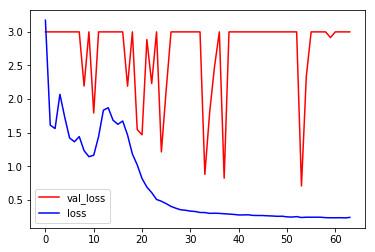

In [5]:
vl, l = history.history['val_loss'], history.history['loss']
vl = np.asarray(vl)
vl[vl > 3] = 3
plt.plot(vl, 'r')
plt.plot(l, 'b')
plt.legend(['val_loss', 'loss'])
plt.show()

(47,)


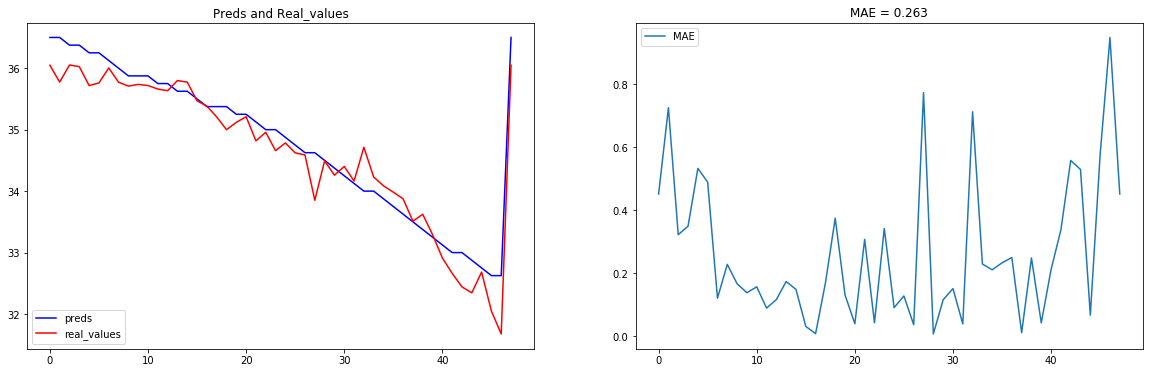

In [2]:
# test
# print('Loading {}...'.format(save_dir + net + '.hdf5'))
# model = load_model(save_dir + net + '.hdf5')
model = load_model('./acceptable_weights/weights_no_K/DenseNet201_no_K_MAE0.263.hdf5')
generator_for_test = generate_generator(test_paths_48, test_labels_48, test_K_48, 48, net=net, with_K=with_K)
# model_paths = sorted([save_dir+i for i in os.listdir(save_dir) if 'MAE' in i], key=lambda x: x.split('MAE')[-1].rstrip('.hdf5'))
# for m in model_paths:
#     print('Loading', m, '...')
#     model = load_model(m)
X_test, Y_test = generator_for_test.__next__()
preds = np.squeeze(model.predict(X_test))
fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 6))
ax0.plot(Y_test, 'b')
ax0.plot(preds, 'r')
ax0.legend(['preds', 'real_values'])
ax0.set_title('Preds and Real_values')
ax1.plot(np.abs(preds - Y_test))
ax1.legend(['MAE'])
MAE = round(np.mean(abs(preds - Y_test)), 3)
ax1.set_title('MAE = {}'.format(MAE))
print(np.unique(preds).shape)
plt.show()

In [18]:
import pandas as pd
label_pred = np.hstack([np.asarray(range(Y_test.shape[0])).reshape(-1, 1), Y_test.reshape(-1, 1), preds.reshape(-1, 1)])
label_pred = pd.DataFrame(label_pred)
label_pred.to_csv(
    os.path.join('preds', 'weights_' + with_K + '_K', '_'.join([net, with_K, 'K_MAE', str(MAE) + '.txt'])),
    index=None,
    header=['index', 'label', 'prediction']
)